In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd


In [ ]:
from sklearn.model_selection import train_test_split

# Load the dataset
df_usual = pd.read_csv("cleaned_data_ready_for_ml.csv")

# Drop work_year (we're not using it to predict salary)
X = df_usual.drop(['salary_in_usd', 'work_year'], axis=1)
y = df_usual['salary_in_usd']

# First, split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [69]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict one sample
sample_row = X_val.iloc[[0]]
actual_salary = y_val.iloc[0]
predicted_salary = rf_model.predict(sample_row)[0]

print("Actual salary:", actual_salary)
print("Predicted salary (Random Forest):", int(predicted_salary))

# Predict full validation set
rf_preds = rf_model.predict(X_val)

# Metrics
print("\n Random Forest Metrics:")
print("MAE:", mean_absolute_error(y_val, rf_preds))
print("MSE:", mean_squared_error(y_val, rf_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_val, rf_preds)))
print("R² Score:", r2_score(y_val, rf_preds))


Actual salary: 184000
Predicted salary (Random Forest): 162514

 Random Forest Metrics:
MAE: 48213.748267363495
MSE: 3609555398.218182
RMSE: 60079.575549584086
R² Score: 0.14777369711895816


In [70]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

sample_row = X_val.iloc[[0]]
actual_salary = y_val.iloc[0]
predicted_salary = lgb_model.predict(sample_row)[0]

print("Actual salary:", actual_salary)
print("Predicted salary (LightGBM):", int(predicted_salary))

# Predict full validation set
lgb_preds = lgb_model.predict(X_val)

# Metrics
print("\n LightGBM Metrics:")
print("MAE:", mean_absolute_error(y_val, lgb_preds))
print("MSE:", mean_squared_error(y_val, lgb_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_val, lgb_preds)))
print("R² Score:", r2_score(y_val, lgb_preds))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 34640, number of used features: 3
[LightGBM] [Info] Start training from score 145360.840300
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [71]:
# Convert prediction to integer and calculate correct_count
def get_correct_count(model, X, y):
    # Predict using the model
    preds = model.predict(X)
    # Convert predictions to integers (round them to the nearest integer)
    preds_int = [round(pred) for pred in preds]
    
    # Compare the predictions to actual values and count correct/incorrect
    correct_count = sum([1 for i in range(len(preds_int)) if preds_int[i] == y.iloc[i]])
    incorrect_count = len(preds_int) - correct_count
    
    return correct_count, incorrect_count

# Example for LightGBM
lgb_correct_count, lgb_incorrect_count = get_correct_count(lgb_model, X_val, y_val)
print(f"LightGBM Correct Predictions: {lgb_correct_count}")
print(f"LightGBM Incorrect Predictions: {lgb_incorrect_count}")

# Example for Random Forest
rf_correct_count, rf_incorrect_count = get_correct_count(rf_model, X_val, y_val)
print(f"Random Forest Correct Predictions: {rf_correct_count}")
print(f"Random Forest Incorrect Predictions: {rf_incorrect_count}")


LightGBM Correct Predictions: 0
LightGBM Incorrect Predictions: 4330
Random Forest Correct Predictions: 0
Random Forest Incorrect Predictions: 4330


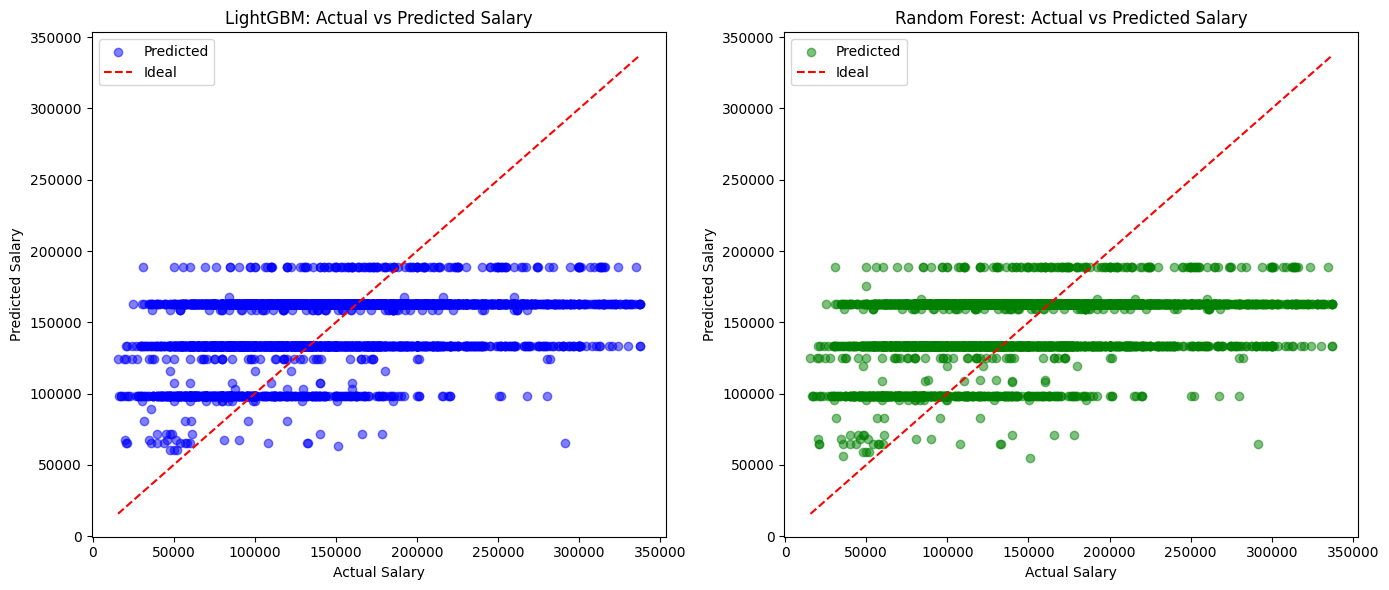

In [72]:
import matplotlib.pyplot as plt

# Predict values
lgb_preds = lgb_model.predict(X_val)
rf_preds = rf_model.predict(X_val)

# Plotting Actual vs Predicted for both models
plt.figure(figsize=(14, 6))

# LightGBM Plot
plt.subplot(1, 2, 1)
plt.scatter(y_val, lgb_preds, alpha=0.5, color='blue', label='Predicted')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Ideal')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('LightGBM: Actual vs Predicted Salary')
plt.legend()

# Random Forest Plot
plt.subplot(1, 2, 2)
plt.scatter(y_val, rf_preds, alpha=0.5, color='green', label='Predicted')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Ideal')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Random Forest: Actual vs Predicted Salary')
plt.legend()

plt.tight_layout()
plt.show()


In [73]:
# Now to Calculate the AUC-ROC curve and work on improving the hyperparameters